Animating oil dispersion on the Salish Sea Atlantis grid. Original code written by Bec Gordon & Javier Porobic, CSIRO, modified to create an animated GIF

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [3]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]


In [4]:
file_id = int(input( ))
scenario = {1 : "5b_TurnPoint_Dilbit_",
            2 : "6a_VancouverHarbour_BunkerC_",
            3 : "7a_JStrait_BunkerC_",
            4 : "4a_ActivePass_Diesel_",}

print("\nScenario running :", scenario[file_id], sep = " ")


Scenario running  :_6a_VancouverHarbour_BunkerC_


In [6]:
# Reading in the file generated by Ocean Parcels

release_start = '2020-07-13'
parcelsFileName = scenario[file_id] + str(release_start) + '_OP_D50_wp3.nc'
atlantis_FileName = "SSAM_Scenario_" + scenario[file_id].split(sep = '_')[0] + "_" + str(release_start) + ".nc"
pfile = xr.open_dataset('results/Ocean-Parcels-Final-Files/'+str(parcelsFileName), decode_cf=True)

lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)

numParticles = lon.shape[0]
print(numParticles)

100


In [8]:
# Defining particle dispersion period

trackDates = []

for i in range(0,numParticles):
    #print(time[i][0])
    trackDates.append(time[i][0])

RDiff = (max(trackDates) - min(trackDates))

minDate = np.datetime64(release_start+"T00:30:00")
outputDT = 60*60 #1 hour
#outputDT = 43200.00

stepsPerDay = int(86400.0/ outputDT)

numStepsPerDT = int(outputDT/3600.0)
trackLength = len(lon[0])
numReleaseDays = RDiff

numReleaseDTS = int(abs(numReleaseDays/np.timedelta64(1, 'h')))
totalNumOfTS = int(numReleaseDTS + trackLength)
print('total number of time steps = ' + str(totalNumOfTS))
print('track length = ' + str(trackLength))

total number of time steps = 193
track length = 169


In [9]:
trackLonsPadded = np.zeros((int(numParticles), totalNumOfTS))
trackLatsPadded = np.zeros((int(numParticles), totalNumOfTS))
particlesAge = np.zeros((int(numParticles), totalNumOfTS))

for trackIndex in range(0,numParticles):
    trackDateDiff = trackDates[trackIndex] - minDate
    trackNumsToPad = int(trackDateDiff/np.timedelta64(1, 'h'))
    
    trackLonsPadded[trackIndex][0:trackNumsToPad] = 0
    trackLatsPadded[trackIndex][0:trackNumsToPad] = 0

    trackLonsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lon[:][trackIndex]
    trackLatsPadded[trackIndex][trackNumsToPad:trackNumsToPad + trackLength] = lat[:][trackIndex]

numSteps = int(trackLength / numStepsPerDT)

In [11]:
# Reading in Atlantis-specific files

savefile_prefix = 'boxes'

afile = xr.open_dataset(str(atlantis_FileName), decode_cf=True)

oil = np.ma.filled(afile.variables['oil'], np.nan)
time = np.ma.filled(afile.variables['t'], np.nan)
#naph = np.ma.filled(afile.variables['Naphthalene']) 
#benzo = np.ma.filled(afile.variables['Benzo']) 
#pyrene = np.ma.filled(afile.variables['Pyrene']) 
#phenan = np.ma.filled(afile.variables['Phenanthrene']) 
num_steps = time.shape[0]
print(num_steps)

17


naph2 = naph.sum(axis=2)
benzo2 = benzo.sum(axis=2)
pyrene2 = pyrene.sum(axis=2)
phenan2 = phenan.sum(axis=2)
fig, ax = plt.subplots(figsize = (14,3))
ax.plot(time, naph2.sum(axis=1), time, phenan2.sum(axis=1), time, pyrene2.sum(axis=1), time, benzo2.sum(axis=1))
ax.set_title('INPUT PAH into Salish Sea Atlantis')
ax.set_ylabel('mgPAH / m^3')
ax.legend(('naphthalene', 'phenanthrene', 'pyrene', 'benzo(a)pyrene'))

In [12]:
# Uncomment below if adding a log scale so the boxes show the proportion of contamination
# import matplotlib.colors as colors

_cmap = cm.coolwarm #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]

for time_index in range(0, num_steps):
   
    plon = trackLonsPadded[:, time_index]
    plat = trackLatsPadded[:, time_index]

    plon = plon[plon<0]
    plat = plat[plat>0]
    time_oil = oil[time_index]
    
    data_df['oil'] = time_oil / (oil.max()/2) * 100 #percentage of total oil
    data_df.loc[land_boxes, 'oil'] = 0

    ax = data_df.plot(figsize=(9, 15), column = 'oil', cmap=_cmap, 
        vmin=-1, vmax = 100,
        legend=True, legend_kwds={'label': "% total oil released"
        },)

    land_df.plot(ax=ax, color='white')
    ax.scatter(plon, plat, s=10, color='orange', zorder=20) #s=0.001
    ax.set_title(time[time_index])
    ax.set_facecolor('white')

    #plt.tight_layout()
    plot_name = savefile_prefix + '_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

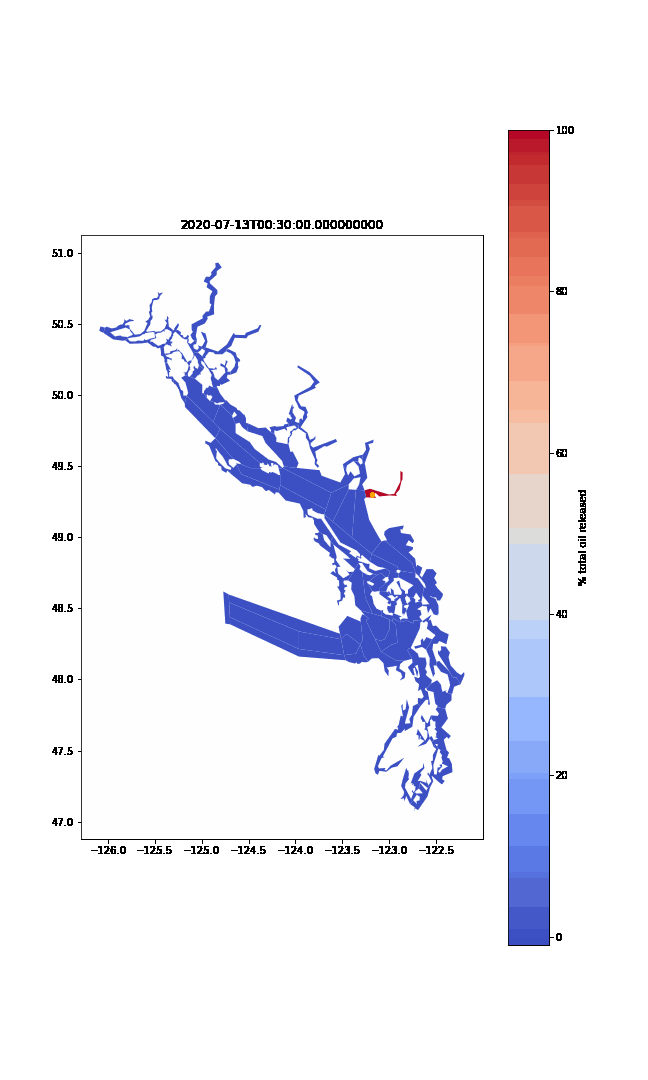

In [13]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = 'Oil_Scenario_' + str(scenario[file_id]) + '_' + str(release_start) +'.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=600, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

# Plot image
from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))